In [1]:
import pandas as pd
import numpy as np

## Bag-of-Words-Matrix

Wir wollen die BoW-Matrix zunächst anhand eines ganz einfachen Korpus von lediglich 3 Sätzen nachbauen und dabei die zugehörigen Scikit-Learn-Funktionen **CountVectorizer** und **TfidfVectorizer** kennenlernen.

In [ ]:
corpus = ["The sun is shining.",
    "The weather is nice.",
    "The sun is shining, the weather is nice and one and one is two."]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X

In [ ]:
# Dünn besetzte Matrix! Daher intern nicht als Tabelle sondern als Liste der Einträge gespeicher!
print(X)

In [ ]:
# als explizite Matrix ist es im Allgemeinen nicht speichereffizient
X.toarray()

In [ ]:
vectorizer.get_feature_names_out()

Nun eine übersichtliche Darstellung der BoW-Matrix, als Matrix mit korrekten Spaltennamen.

In [ ]:
df_matrix = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
df_matrix

Ein neues Dokument (z.B. eine Suchanfrage) lässt sich mit dem trainierten Vektorizer leicht in einen BoW-Vektor überführen.

In [ ]:
vectorizer.transform(["How is the weather?"]).toarray()

## Cosine-Similarity

Für zwei Vektoren $\vec{v}, \vec{w} \in \mathbb{R}$ ist die Cosine-Similarity definiert als der Kosinus ihres einschließenden Winkels:
$$\text{cosine-similarity}(\vec{v}, \vec{w}) = \cos{\alpha} = \frac{\vec{v} \cdot \vec{w}}{|\vec{v}| \cdot |\vec{w}|} = \frac{\sum_{i=1}^n v_i\cdot w_i}{\sqrt{\sum_{i=1}^n v_i^2} \cdot \sqrt{\sum_{i=1}^n w_i^2}}$$

Zunächst beispielhaft die Cosine-Similarity zwischen dem ersten und dem dritten Satz:

In [ ]:
# explizite Berechnung
np.dot(X[0].toarray(), X[2].toarray().T) / (np.linalg.norm(X[0].toarray()) * np.linalg.norm(X[2].toarray())) 

Mit Hilfe von scikit-learn lassen sich auch alle paarweisen Ähnlichkeiten direkt bestimmen:

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(X)

## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_ifidf = TfidfVectorizer()
X_tfidf = vectorizer_ifidf.fit_transform(corpus)

np.set_printoptions(precision=3)
print(X_tfidf.toarray())

In [ ]:
cosine_similarity(X_tfidf)

In [ ]:
X.toarray()

In [ ]:
X_tfidf.toarray()

Wollen die obigen Werte in X_tfidf rekonstruieren, indem wir die Formel auf X anwenden.

$$\text{tf-idf}(d, w) = \text{tf}(d, w) \cdot \text{idf}(w) = \text{df}(d, w) \cdot (\log(\frac{N+1}{\text{df}(w) + 1}) +1)$$

In [ ]:
# TF-Werte entsprechen den rohen Anzahlen
TF = X.toarray()
print(TF)

# Für jedes Wort alle relevanten Dokumente zählen:
DF = np.sum(TF > 0, axis=0)
print(DF)

# Formel gemäß scikit-learn-Dokumentation:
IDF = np.log((len(corpus) +1) / (DF +1)) +1 
print(IDF)

TFIDF = TF * IDF # sollte laut Doku eigentlich passen, aber tut es noch nicht :-(
print(TFIDF)

# scikit-learn normalisiert alle Dokumentvektoren auf Länge 1. Zunächst Länge bestimmen:
lengths = np.sqrt(np.sum(TFIDF**2, axis=1, keepdims=True))
print(lengths)

# jeden Dokumentvektor durch Länge teilen
TFIDF = TFIDF / lengths
print(TFIDF) # diese Matrix stimmt mit dem Resultat von TfidfVectorizer überein :-)

In [ ]:
X = np.arange(15).reshape(3, 5)
bla = np.sum(X, axis=1, keepdims=True)
X / bla

# Movie Reviews

Daten von https://ai.stanford.edu/~amaas/data/sentiment/

In [2]:
df = pd.read_csv("movie_data.csv")
print(len(df))
df.head()

50000


,review,sentiment
0,at a Saturday matinee in my home town. I went ...,0
1,I love this movie. It is the first film Master...,1
2,"In the voice over which begins the film, Hughi...",1
3,"!!! Spoiler alert!!!<br /><br />The point is, ...",0
4,"This is an excellent film. No, it's not Mel Gi...",1


In [3]:
import re
import nltk

In [ ]:
# Die folgenden beiden Zeilen müssen nur einmalig durchgeführt werden!
#nltk.download("stopwords")
#nltk.download("punkt")

In [4]:
stopwords = nltk.corpus.stopwords.words("english")

def preprocessing(text):
    text = re.sub(r"<[^>]+>", "", text)
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stopwords]
    text = " ".join(filtered_tokens)
    return text

df["review_clean"] =  df["review"].apply(preprocessing)
df.head()

,review,sentiment,review_clean
0,at a Saturday matinee in my home town. I went ...,0,Saturday matinee home town . I went older frie...
1,I love this movie. It is the first film Master...,1,I love movie . It first film Master P ever don...
2,"In the voice over which begins the film, Hughi...",1,"In voice begins film , Hughie ( Billy Connolly..."
3,"!!! Spoiler alert!!!<br /><br />The point is, ...",0,"! ! ! Spoiler alert ! ! ! The point , though ,..."
4,"This is an excellent film. No, it's not Mel Gi...",1,"This excellent film . No , 's Mel Gibson `` Br..."


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

## Zusätzliche Einschränkungen an das Vokabular:
## - jeder Begriff soll in höchstens 50% der Dokumente vorkommen
## - jeder Begriff soll in mindestens 5 Dokumenten vorkommen
vectorizer_ifidf = TfidfVectorizer(max_df=0.5, min_df=5)
X_tfidf = vectorizer_ifidf.fit_transform(df["review_clean"])
print(X_tfidf.shape)

(50000, 37088)


## Hausaufgabe

Können wir ein Modellbauen, welches auf Basis des Text erkennt, ob die Bewertung positiv (= 1) oder negativ (= 0) ist?

- Den Datensatz in Training und Test splitten.
- Die bereinigten Reviews in eine TF-IDF-Matrix überführen und ein logistischer Regression zur Prädiktion der Sentiments trainieren.
- die Modellgüte auf den Testdaten evaluieren.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df["sentiment"])
print(X_train.shape[0], X_test.shape[0])

37500 12500


In [11]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X_train, y_train)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      6242
           1       0.89      0.91      0.90      6258

    accuracy                           0.90     12500
   macro avg       0.90      0.90      0.90     12500
weighted avg       0.90      0.90      0.90     12500



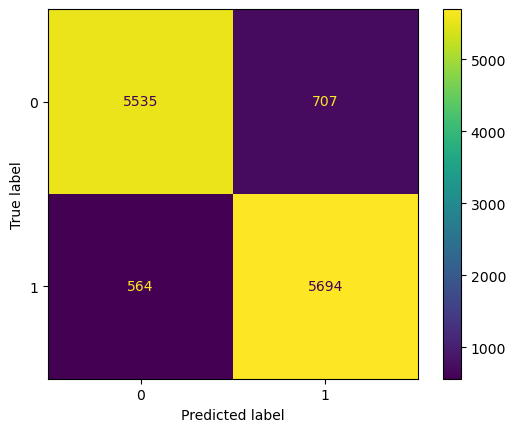

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

print(classification_report(y_true = y_test, y_pred = logistic.predict(X_test)))
ConfusionMatrixDisplay.from_estimator(logistic, X_test, y_test)

Einblick in das mogistische Modell: Welche Worte haben einen besonders großen positiven/negativen Einfluss?

In [22]:
vocab = pd.DataFrame({
    "coef": logistic.coef_.flatten(),
    "words": vectorizer_ifidf.get_feature_names_out()
    })
vocab = vocab.sort_values("coef")
vocab

,coef,words
36648,-10.500298,worst
2641,-8.341565,bad
35924,-7.765719,waste
2534,-7.717291,awful
4073,-6.900214,boring
...,...,...
36554,5.384187,wonderful
3377,5.391947,best
24277,5.579742,perfect
11533,7.140612,excellent


In [24]:
vocab.tail(15)

,coef,words
36108,4.179831,well
13338,4.185614,fun
19697,4.185640,love
32105,4.185721,superb
12129,4.322324,favorite
11043,4.363169,enjoyed
4396,4.415998,brilliant
33440,4.654821,today
19702,4.917735,loved
1363,5.060956,amazing
